In [1]:
import pandas as pad
import numpy as nup
import glob
import soundfile
import os
import sys

In [2]:
import librosa
import librosa.display
import seaborn as sbn
import matplotlib.pyplot as mplt
from sklearn import metrics

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from IPython.display import Audio

In [4]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
RavdessData = "D:\\Ravdess\\audio_speech_actors_01-24\\"

In [6]:
ravdessDirectoryList = os.listdir(RavdessData)
fileEmotion = []
filePath = []
for actor_dir in ravdessDirectoryList:
    actor_path = os.path.join(RavdessData, actor_dir)
    actor_files = os.listdir(actor_path)
    for file in actor_files:
        file_path = os.path.join(actor_path, file)
        part = file.split('.')[0]
        part = part.split('-')
        if len(part) >= 3:
            fileEmotion.append(int(part[2]))
            filePath.append(file_path)
        else:
            print(f"Skipping file {file}. Expected format not found.")
emotion_df = pad.DataFrame(fileEmotion, columns=['Emotions'])
path_df = pad.DataFrame(filePath, columns=['Path'])
Ravdess_df = pad.concat([emotion_df, path_df], axis=1)


In [7]:
Ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4:'sad', 5: 'angry', 6: 'fear',7: 'disgust',8: 'surprise'},inplace = True)
Ravdess_df.head()

,Emotions,Path
0,neutral,D:\Ravdess\audio_speech_actors_01-24\Actor_01\...
1,neutral,D:\Ravdess\audio_speech_actors_01-24\Actor_01\...
2,neutral,D:\Ravdess\audio_speech_actors_01-24\Actor_01\...
3,neutral,D:\Ravdess\audio_speech_actors_01-24\Actor_01\...
4,calm,D:\Ravdess\audio_speech_actors_01-24\Actor_01\...


In [8]:
dataPath = pad.concat([Ravdess_df], axis = 0)
dataPath.to_csv("data_path.csv",index=False)
dataPath.head()

,Emotions,Path
0,neutral,D:\Ravdess\audio_speech_actors_01-24\Actor_01\...
1,neutral,D:\Ravdess\audio_speech_actors_01-24\Actor_01\...
2,neutral,D:\Ravdess\audio_speech_actors_01-24\Actor_01\...
3,neutral,D:\Ravdess\audio_speech_actors_01-24\Actor_01\...
4,calm,D:\Ravdess\audio_speech_actors_01-24\Actor_01\...


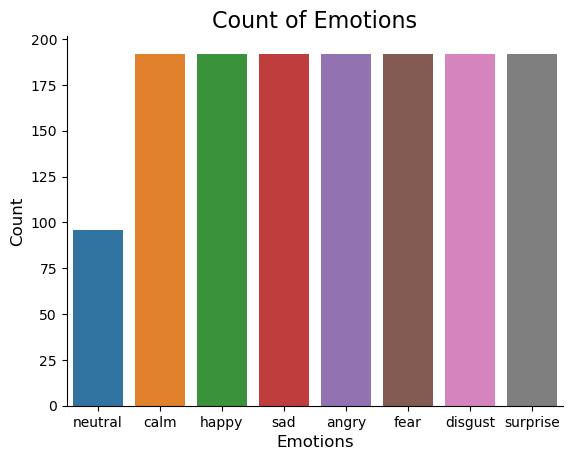

In [9]:
mplt.title('Count of Emotions', size=16)
sbn.countplot(data=Ravdess_df, x='Emotions')
mplt.ylabel('Count', size=12)
mplt.xlabel('Emotions', size=12)
sbn.despine(top=True, right=True, left=False, bottom=False)
mplt.show()

In [10]:
emotion = 'fear'
path = nup.array(Ravdess_df['Path'][Ravdess_df['Emotions'] == emotion])[1]
data, samplingRate = librosa.load(path)
def createWaveplot(data, samplingRate, emotion):
    mplt.figure(figsize=(12, 4))
    mplt.title(f'Waveplot - Emotion: {emotion}')
    mplt.plot(nup.arange(len(data)) / samplingRate, data)
    mplt.xlabel('Time (s)')
    mplt.ylabel('Amplitude')
    mplt.show()

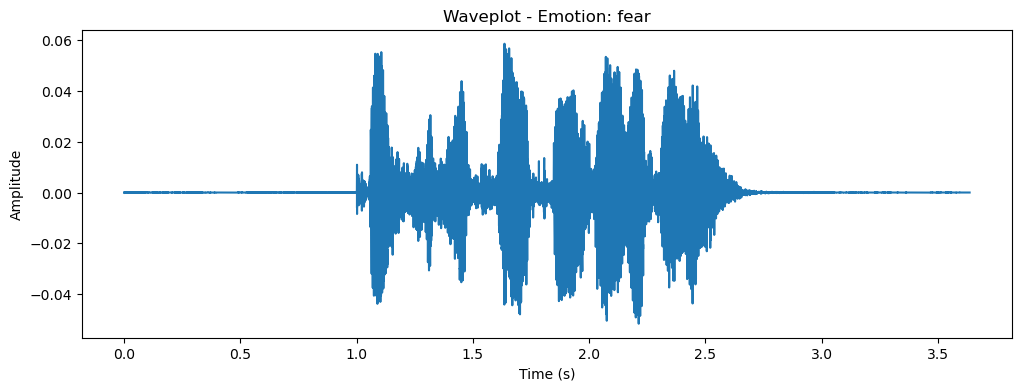

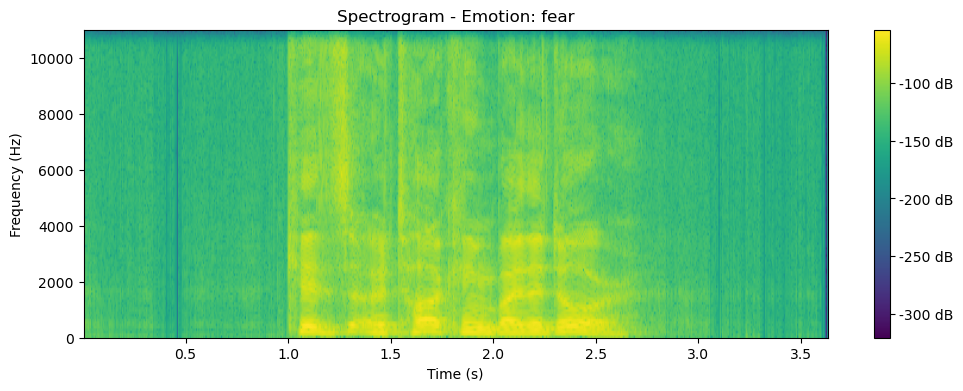

In [11]:
def createSpectrogram(data, samplingRate, emotion):
    mplt.figure(figsize=(12, 4))
    mplt.title(f'Spectrogram - Emotion: {emotion}')
    mplt.specgram(data, Fs=samplingRate)
    mplt.xlabel('Time (s)')
    mplt.ylabel('Frequency (Hz)')
    mplt.colorbar(format="%+2.0f dB")
    mplt.show()
createWaveplot(data, samplingRate, emotion)
createSpectrogram(data, samplingRate, emotion)
Audio(path)


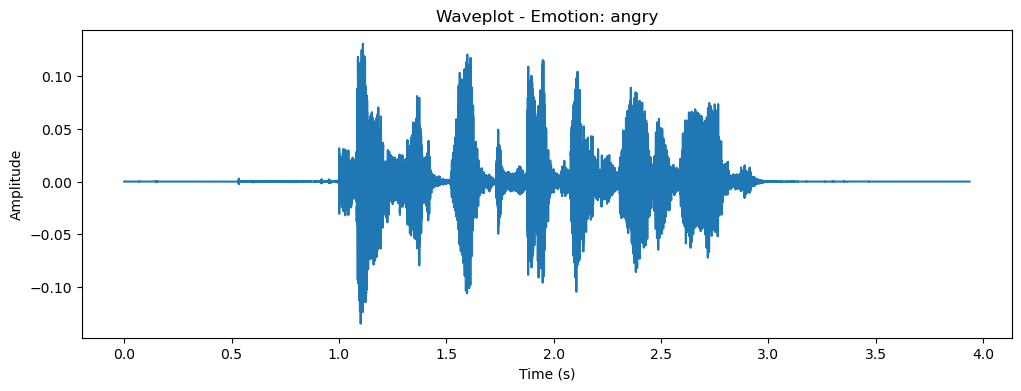

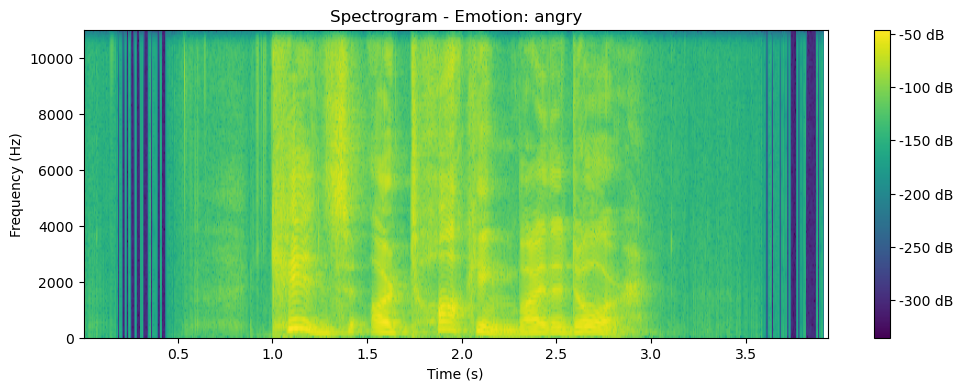

In [12]:
emotion = 'angry'
path = nup.array(Ravdess_df['Path'][Ravdess_df['Emotions'] == emotion])[1]
data, samplingRate = librosa.load(path)
createWaveplot(data, samplingRate, emotion)
createSpectrogram(data, samplingRate, emotion)
Audio(path)


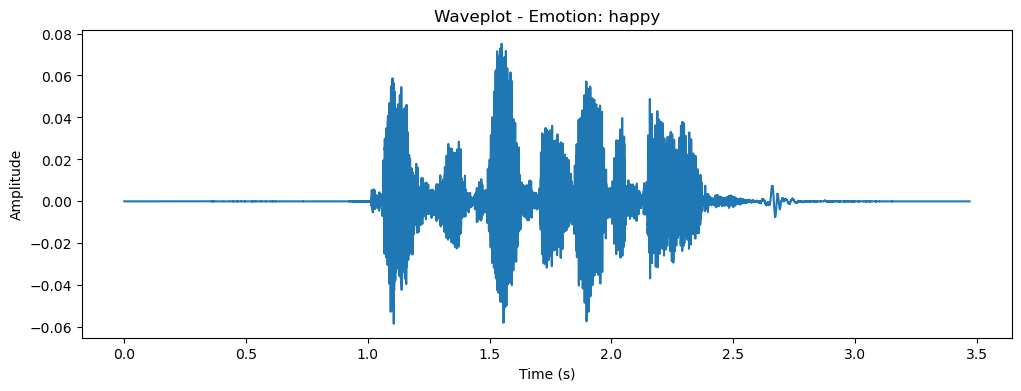

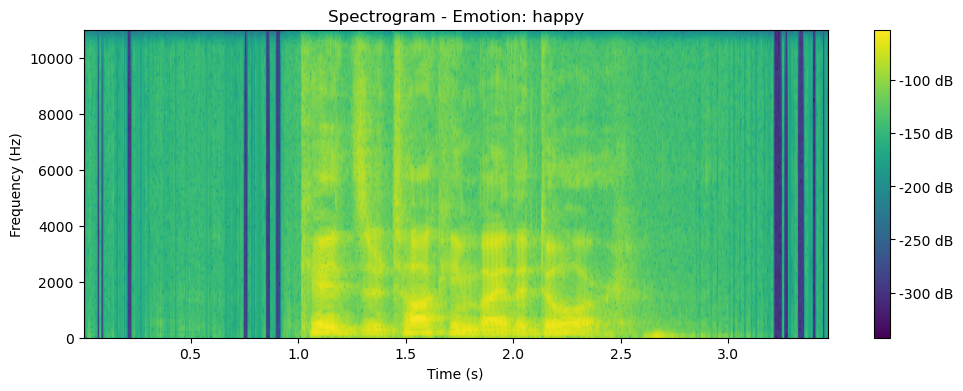

In [13]:
emotion = 'happy'
path = nup.array(Ravdess_df['Path'][Ravdess_df['Emotions'] == emotion])[1]
data, samplingRate = librosa.load(path)
createWaveplot(data, samplingRate, emotion)
createSpectrogram(data, samplingRate, emotion)
Audio(path)

In [14]:
def noise(data):
    noiseAmp = 0.035*nup.random.uniform()*nup.amax(data) 
    data = data + noiseAmp*nup.random.normal(size=data.shape[0]) 
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shiftRange = int(nup.random.uniform(low=-5, high = 5)*1000) 
    return nup.roll(data, shiftRange)


def pitch(data, samplingRate, pitch_shift_factor=2):
    return librosa.effects.pitch_shift(data, n_steps=pitch_shift_factor, sr=samplingRate)

In [15]:
path = nup.array(Ravdess_df.Path)[1]
data, sampleRate = librosa.load(path)

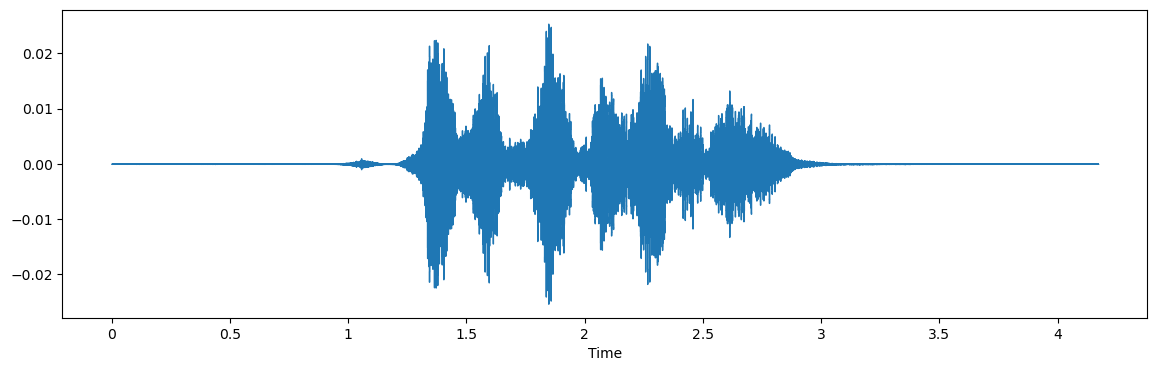

In [16]:
x = stretch(data)
mplt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampleRate)
mplt.show()

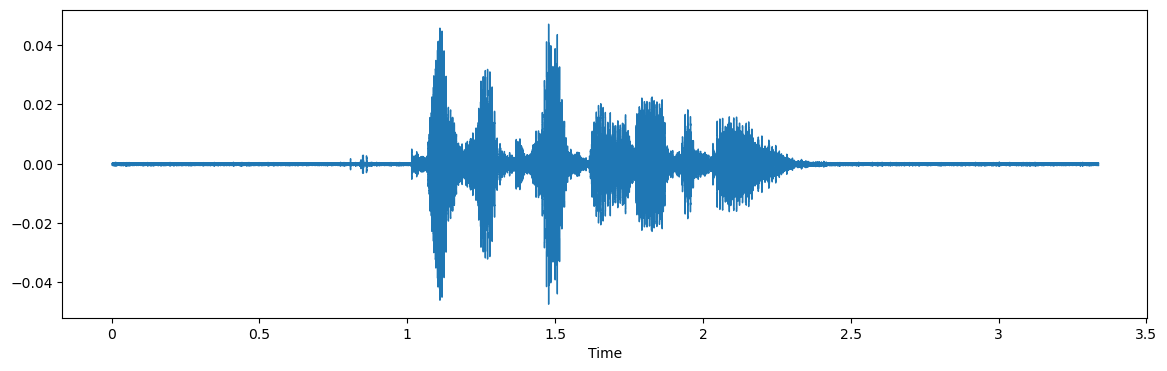

In [17]:
x = noise(data)
mplt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampleRate) 
Audio(x, rate = sampleRate)

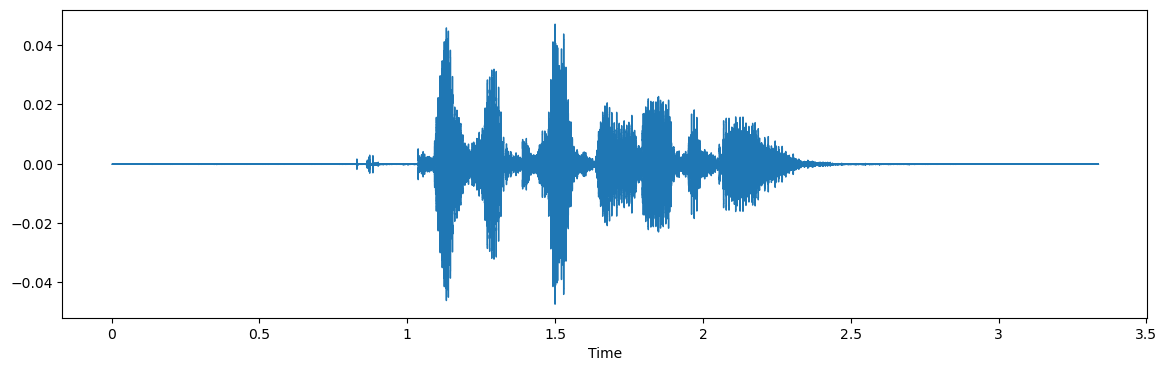

In [18]:
x = shift(data)
mplt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampleRate) 
Audio(x, rate=sampleRate)

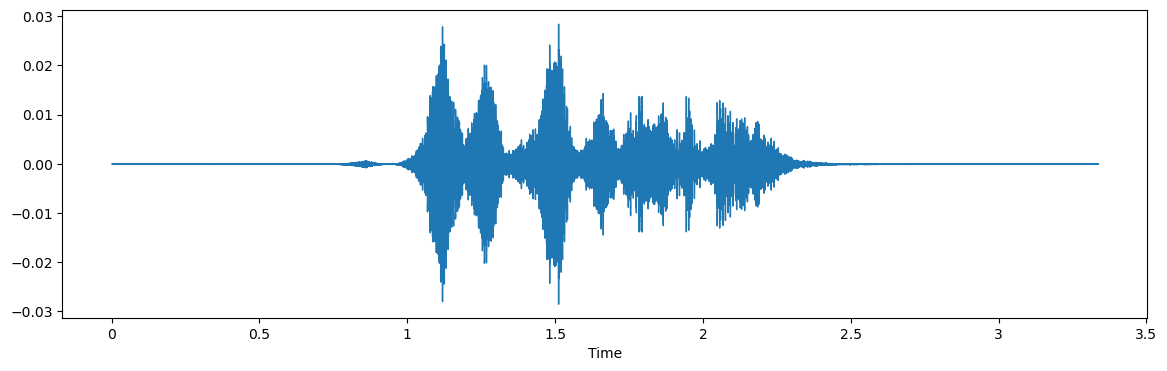

In [19]:
x = pitch(data, samplingRate)

mplt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=samplingRate)
mplt.show()
Audio(x, rate=samplingRate)

In [20]:
def extractFeature(fileName, mfcc, chroma, mel):
    with soundfile.SoundFile(fileName) as soundFile:
        X = soundFile.read(dtype="float32")
        sampleRate = soundFile.samplerate

        if chroma:
            stft = nup.abs(librosa.stft(X))

        result = None

        if mfcc:
            mfccs = nup.mean(librosa.feature.mfcc(y=X, sr=sampleRate, n_mfcc=40).T, axis=0)
            if result is None:
                result = mfccs.reshape(1, -1)  # Reshape to 2D
            else:
                result = nup.hstack((result, mfccs.reshape(1, -1)))

        if chroma:
            chroma = nup.mean(librosa.feature.chroma_stft(S=stft, sr=sampleRate).T, axis=0)
            if result is None:
                result = chroma.reshape(1, -1)  # Reshape to 2D
            else:
                result = nup.hstack((result, chroma.reshape(1, -1)))

        if mel:
            mel = nup.mean(librosa.feature.melspectrogram(y=X, sr=sampleRate).T, axis=0)
            if result is None:
                result = mel.reshape(1, -1)  # Reshape to 2D
            else:
                result = nup.hstack((result, mel.reshape(1, -1)))

    return result


In [21]:
emotions={
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05':'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
observedEmotions=['calm','happy','fearful','disgust']

In [22]:
def loadData(test_size=0.23, fixed_length=100):
    x, y = [], []
    max_len = fixed_length
    for file in glob.glob("D:\\Ravdess\\Actor_*\\*.wav"): 
        fileName = os.path.basename(file)
        emotion1 = emotions[fileName.split("-")[2]] 
        if emotion1 not in observedEmotions:
            continue
        feature = extractFeature(file, mfcc=True, chroma=True, mel=True)
        
        feature = nup.pad(feature, pad_width=((0, 0), (0, max(0, fixed_length - feature.shape[1]))), mode='constant')[:, :fixed_length]

        x.append(feature)
        y.append(emotion1)

    x_train, x_test, y_train, y_test = train_test_split(nup.array(x), y, test_size=test_size, random_state=9)
    return x_train, x_test, y_train, y_test

In [23]:
xTrain, xTest, yTrain, yTest = loadData(test_size=0.23, fixed_length=100)

In [24]:
print((xTrain.shape[0], xTest.shape[0]))

(591, 177)


In [25]:
print(f'Features extracted: {xTrain.shape[1]}')

Features extracted: 1


In [26]:
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=1000)

In [27]:
xTrain = xTrain.reshape(xTrain.shape[0], -1)
model.fit(xTrain, yTrain)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=1000)

In [28]:
expected_Of_y = yTest
xTest_flattened = xTest.reshape(xTest.shape[0], -1)
yPred = model.predict(xTest_flattened)

In [29]:
print(metrics.confusion_matrix(expected_Of_y, yPred))

[[44  5  0  4]
 [17 21  0  8]
 [ 7  3 15 10]
 [ 7  2  4 30]]


In [30]:
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

        calm       0.59      0.83      0.69        53
     disgust       0.68      0.46      0.55        46
     fearful       0.79      0.43      0.56        35
       happy       0.58      0.70      0.63        43

    accuracy                           0.62       177
   macro avg       0.66      0.60      0.61       177
weighted avg       0.65      0.62      0.61       177



In [31]:
accuracy = accuracy_score(y_true=yTest, y_pred=yPred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 62.15%
